# SpO2 calibration for Thor
康泰醫學血氧模擬儀 MS100



## import module and declare function

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import os,sys
import scipy.signal as signal
from scipy.interpolate import interp1d
import re
import pandas as pd
import math
plt.style.use('ggplot')
sys.path.insert(0, os.path.abspath('../lib'))

import sig_proc as sp
import file_read

import csv

# Normalize to mv
def value_trans(data):
    data = data*1.2/2097151.0
    return data


def RMS_amp(data):
    squaredData = []
    for val in data:
        squaredData.append(val**2)
    
    ms = np.mean(squaredData)
    rms = math.sqrt(ms)
    return rms


def snr_calc(signal):
    return 20* math.log(np.abs(np.mean(signal)/np.std(signal)),10)



## Main function

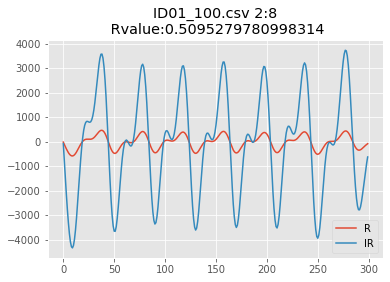

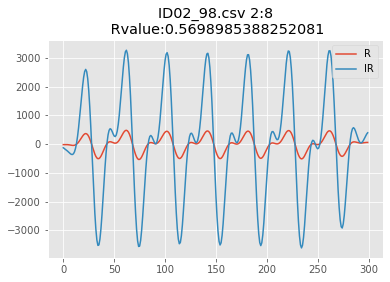

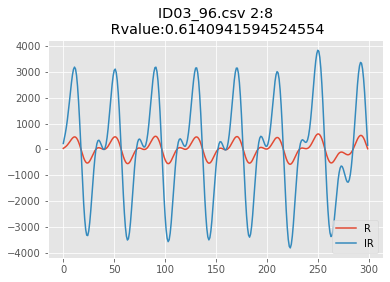

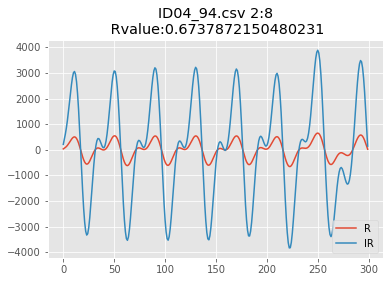

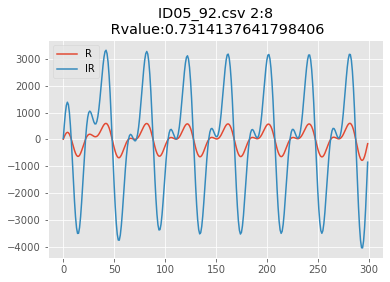

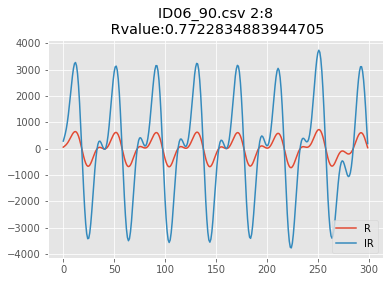

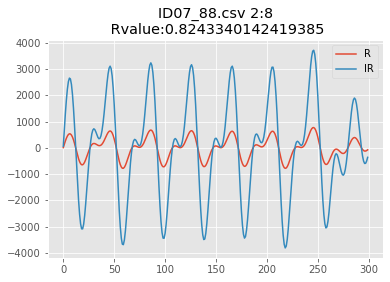

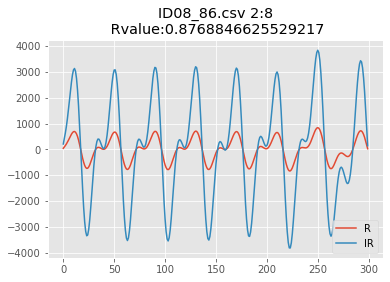

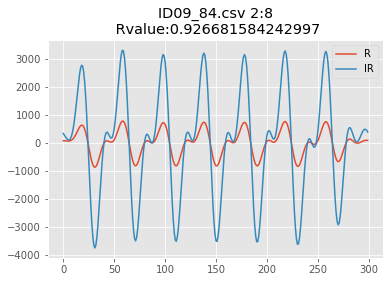

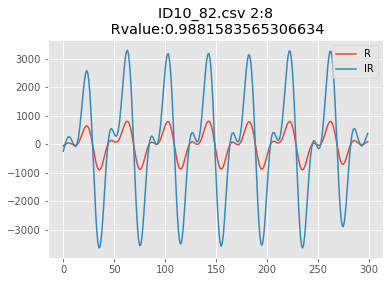

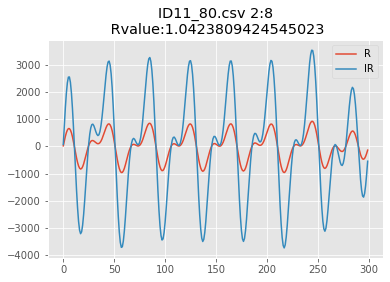

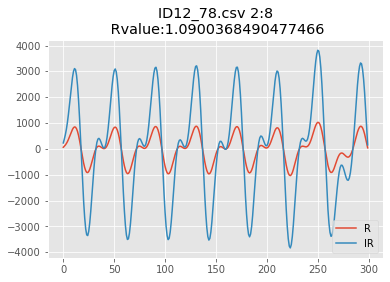

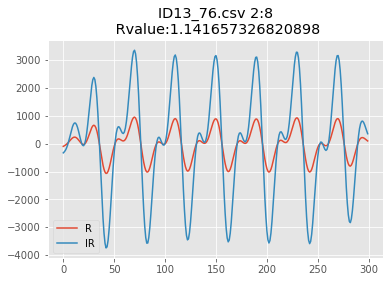

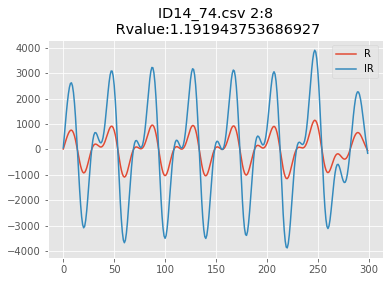

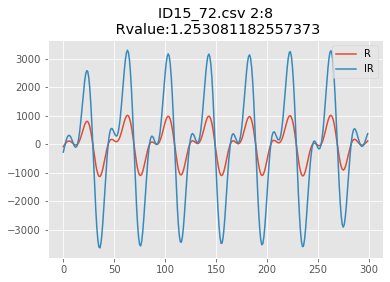

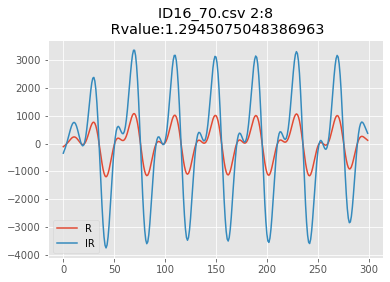

In [2]:

folder = "spo2/simulator"


''' Select the duration of PPG segment in seconds'''
start_sec = 2
period = 6
overlap = 2
# overlap = 0
# data_length = len(G_y)/sr
hop_length = period - overlap
num_watching_period = 1
# num_watching_period = int((data_length - overlap)/hop_length) -1

vsTable = {
    'spo2':[],
    'R_PI':[],
    'IR_PI':[],
    'R_value':[],
    'R_squared':[]
    
}


sr = 50

file_path = os.path.join("../../data", folder)


for subject in os.listdir(file_path):
    full_path = os.path.join(file_path, subject)
    data = file_read.thor2_reader(full_path)

    R = data['PPG_R']
    IR = data['PPG_IR']
    R = np.array(R)
    IR = np.array(IR)
        

    # Filter parameters
    bp_b, bp_a = sp.bp_filter(0.8, 3, sr, 4)
    lp_b, lp_a = sp.lp_filter(3, sr, 4)

    for n in range(num_watching_period):
        t1 = start_sec +  (period-overlap) * n
        t2 = t1 + period
        s1 = int(t1*sr)
        s2 = int(t2*sr )

        '''''''''''''''''''''''''''''''''''''''
        Signal Preprocessing
        '''''''''''''''''''''''''''''''''''''''
        IR_segment = np.array(IR[s1:s2])
        R_segment = np.array(R[s1:s2])
        
        
        ''' AC component '''
        filt_IR = signal.filtfilt(bp_b,bp_a, IR_segment)
        filt_R = signal.filtfilt(bp_b, bp_a, R_segment)

        ''' DC component '''
        R_DC_component = signal.filtfilt(lp_b,lp_a, R_segment)
        IR_DC_component = signal.filtfilt(lp_b,lp_a, IR_segment)

        ''' Calculate R value by using RMS method'''
        R_divide = filt_R/R_DC_component
        R_RMS = RMS_amp(R_divide)

        IR_divide = filt_IR/IR_DC_component
        IR_RMS = RMS_amp(IR_divide)
        R_value = R_RMS/ IR_RMS

        f = subject.split('.')[0]
        spo2 = int(f.split('_')[-1])
        vsTable['spo2'].append(spo2)
        vsTable['R_PI'].append(R_RMS)
        vsTable['IR_PI'].append(IR_RMS)
        vsTable['R_value'].append(R_value)
        vsTable['R_squared'].append(R_value*R_value)
        '''''''''''''''''''''''''''''''''''
        plot filgure
        '''''''''''''''''''''''''''''''''''
        font_size = 14
        fig_size  = (6,4)
            
        plt.figure(figsize=fig_size)
        plt.title(subject + " {}:{}\n Rvalue:{}".format(t1,t2, R_value))
        plt.plot(filt_R, label='R')
        plt.plot(filt_IR, label='IR')
        plt.legend()

    # plt.figure()
    # plt.title('{}, spo2:{}'.format(subject, int(spo2_value+0.5)))
    # x = np.arange(2)
    # width = 0.3
    # plt.bar(x,[R_RMS, IR_RMS], width, bottom=None, align='center',
    #         color=['#E24A33', '#348ABD' ])
    # plt.xticks(x, ['R', 'IR'], fontsize=12)
    # plt.xlabel('LED')
    # plt.ylabel('PI')


In [4]:
import pandas as pd
df = pd.DataFrame(vsTable)
df

,spo2,R_PI,IR_PI,R_value,R_squared
0,100,0.008702,0.017078,0.509528,0.259619
1,98,0.008678,0.015228,0.569899,0.324784
2,96,0.010008,0.016297,0.614094,0.377112
3,94,0.011002,0.016328,0.673787,0.453989
4,92,0.011954,0.016344,0.731414,0.534966
5,90,0.012529,0.016224,0.772283,0.596422
6,88,0.012792,0.015518,0.824334,0.679527
7,86,0.014310,0.016319,0.876885,0.768927
8,84,0.014233,0.015359,0.926682,0.858739
9,82,0.015117,0.015299,0.988158,0.976457


Text(0.5, 0, 'SpO2')

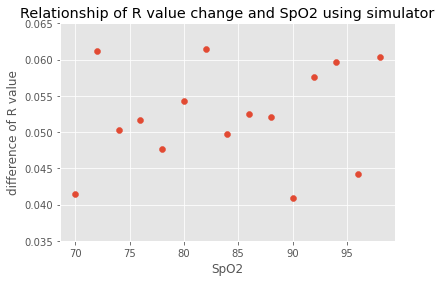

In [10]:
dif = np.diff(df.R_value)
plt.title('Relationship of R value change and SpO2 using simulator')
plt.scatter(df.spo2[1:], dif)
plt.ylim(0.035, 0.065)
plt.ylabel('difference of R value')
plt.xlabel('SpO2')

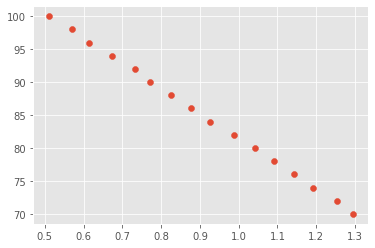

In [57]:

plt.figure()
plt.scatter(df.R_value, df.spo2)

In [16]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

# X = np.array([[df.R_value, df.R_squared]])
X=df[['R_value', 'R_squared']]
model.fit(X, df.spo2)

# xfit = np.linspace(0, 10, 100)
# yfit = model.predict(xfit[:, np.newaxis])

# plt.scatter(x, y)
# plt.plot(xfit, yfit);

print("Model coeficient:    ", model.coef_)
print("Model intercept:", model.intercept_)

Model coeficient:     [-37.87092295  -0.16106339]
Model intercept: 119.46380188927183


In [47]:
serial1 = np.array([1,2,3,4,5])
serial2 = np.array([6,3,7,3,7])
test1 = RMS_amp(serial1/serial2)
test2 = RMS_amp(serial1) / RMS_amp(serial2)

## Real data

Text(0, 0.5, 'SpO2')

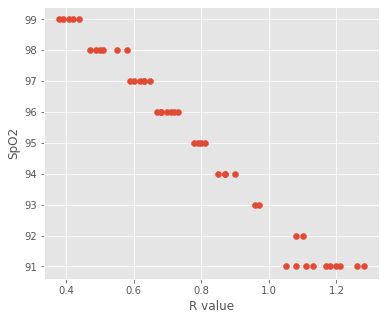

In [32]:
valid_spo2 = [91, 91,91, 97, 97, 97, 98, 96, 94, 91, 
              96, 95, 95, 94, 93, 91, 91, 97,97, 96, 
              96, 96, 95, 94, 95, 94, 93, 92, 91, 92, 
              91, 91, 91, 96,96, 97, 98, 98, 98, 98, 
              99, 99, 99, 99, 99, 98]
valid_R = [1.26, 1.11,1.05, 0.6, 0.63, 0.65, 0.58, 0.68, 0.87, 1.17, 
           0.7, 0.8, 0.81, 0.87, 0.96, 1.08, 1.13, 0.59,0.63, 0.68,
           0.72, 0.73, 0.78, 0.85, 0.79, 0.9, 0.97, 1.1, 1.2, 1.08, 
           1.21, 1.28, 1.18, 0.71, 0.67, 0.62, 0.55, 0.51, 0.5, 0.49, 
           0.41, 0.44, 0.38, 0.39, 0.42, 0.47]

valid_Rsq = [R**2 for R in valid_R]

feat = {
    'spo2':valid_spo2,
    'R_value': valid_R,
    'R_squared':valid_Rsq
}


df_calb = pd.DataFrame(feat)
plt.figure(figsize=(6,5))
plt.scatter(valid_R, valid_spo2)
plt.xlabel('R value')
plt.ylabel('SpO2')

In [25]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

# X = np.array([[df.R_value, df.R_squared]])
X=df_calb[['R_value', 'R_squared']]
model.fit(X, df_calb.spo2)

# xfit = np.linspace(0, 10, 100)
# yfit = model.predict(xfit[:, np.newaxis])

# plt.scatter(x, y)
# plt.plot(xfit, yfit);

print("Model coeficient:    ", model.coef_)
print("Model intercept:", model.intercept_)

Model coeficient:     [-12.75886139   1.39192419]
Model intercept: 104.14801275562009
